In [1]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#imports and data upload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor


sns.set()

df = pd.read_csv("/content/drive/MyDrive/CAS/VeloCheckZH/data/processed/data_for_model_engineered.csv")
#df = pd.read_csv("../data/processed/data_for_model_engineered.csv")
df['Datum'] = pd.to_datetime(df['Datum'])
df['weekday'] = df['weekday'].astype('category')
df= pd.get_dummies(df, columns=['weekday'], prefix='weekday')
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23799 entries, 0 to 23798
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Standort_ID              23799 non-null  int64         
 1   Datum                    23799 non-null  datetime64[ns]
 2   Koord_Ost                23799 non-null  int64         
 3   Koord_Nord               23799 non-null  int64         
 4   Velo                     23799 non-null  float64       
 5   year                     23799 non-null  int64         
 6   day_of_year              23799 non-null  int64         
 7   Niederschlag             23799 non-null  float64       
 8   Temperatur Durchschnitt  23799 non-null  float64       
 9   weekend                  23799 non-null  bool          
 10  is_holiday               23799 non-null  bool          
 11  month                    23799 non-null  int64         
 12  week                     23799 n

In [3]:
# Definition of feature and target

TARGET = "Velo"

exclude = [
    "Velo",
    # "Velo_log",       # nur falls vorhanden
    "Datum",            # rohes Datum nicht direkt ins Modell
    #"Standort_ID",
    "Koord_Ost",
    "Koord_Nord",
    "year",
    "week",
    "month",
    "quarter",
    "day_of_year",
    "year_length",
    "velo_roll7",
    "weekend"
]

features = [c for c in df.columns if c not in exclude]
print("Anzahl Features:", len(features))
features

len(features), features[:]


Anzahl Features: 13


(13,
 ['Standort_ID',
  'Niederschlag',
  'Temperatur Durchschnitt',
  'is_holiday',
  'sin_day',
  'cos_day',
  'weekday_Dienstag',
  'weekday_Donnerstag',
  'weekday_Freitag',
  'weekday_Mittwoch',
  'weekday_Montag',
  'weekday_Samstag',
  'weekday_Sonntag'])

# Train/Test Split

In [4]:
X = df[features]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((19039, 13), (4760, 13))

In [5]:
#helperfunction
def evaluate_model(name, y_true, y_pred, results_list):
    # MSE without squared-parameter (works in all sklearn versions)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    results_list.append({
        "model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
    })
    print(f"{name}: RMSE={rmse:.1f}, MAE={mae:.1f}, R²={r2:.3f}")

In [6]:
#Baseline: Mean Predictor
results = []

y_pred_baseline = np.ones_like(y_test) * y_train.mean()
evaluate_model("Baseline_Mean", y_test, y_pred_baseline, results)


Baseline_Mean: RMSE=1126.9, MAE=840.7, R²=-0.000


# Model 1: Linear Regression

In [7]:
lin_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

lin_pipe.fit(X_train, y_train)
y_pred_lin = lin_pipe.predict(X_test)

evaluate_model("LinearRegression", y_test, y_pred_lin, results)


LinearRegression: RMSE=975.1, MAE=727.8, R²=0.251


# Model 2: Random Forest

In [8]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

evaluate_model("RandomForest", y_test, y_pred_rf, results)


RandomForest: RMSE=321.2, MAE=187.9, R²=0.919


# Model 3: XGBoost

In [9]:
df["Standort_ID"] = df["Standort_ID"].astype("category")

xgb = XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    enable_categorical=True
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

evaluate_model("XGBoost", y_test, y_pred_xgb, results)


XGBoost: RMSE=274.2, MAE=151.0, R²=0.941


In [10]:
#Vergleich der Tabellen
results_df = pd.DataFrame(results)
results_df

,model,RMSE,MAE,R2
0,Baseline_Mean,1126.902108,840.713029,-0.000026
1,LinearRegression,975.148839,727.752982,0.251174
2,RandomForest,321.223000,187.891556,0.918745
3,XGBoost,274.169007,151.012034,0.940806


from matplotlib import pyplot as plt
results_df['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='RMSE', y='MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='MAE', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['R2']
  ys = series['RMSE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('R2', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('R2')
_ = plt.ylabel('RMSE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['R2']
  ys = series['MAE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('R2', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('R2')
_ = plt.ylabel('MAE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['R2']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'R2'}, axis=1)
              .sort_values('R2', ascending=True))
  xs = counted['R2']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('R2', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('R2')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
results_df['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='RMSE', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='MAE', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='R2', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

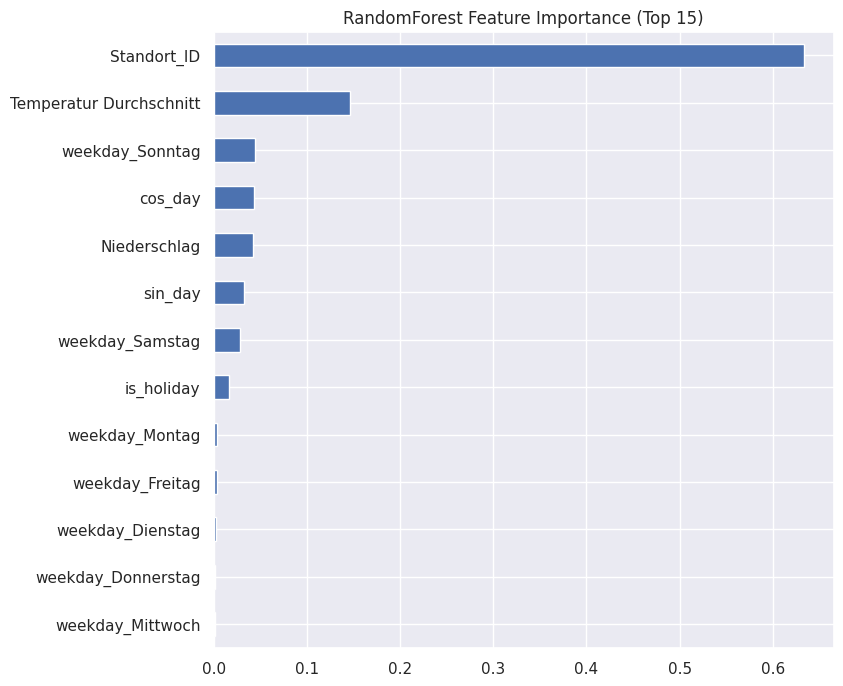

In [11]:
importances_rf = pd.Series(rf.feature_importances_, index=features)
importances_rf.sort_values().tail(15).plot(kind="barh", figsize=(8,8))
plt.title("RandomForest Feature Importance (Top 15)")
plt.show()


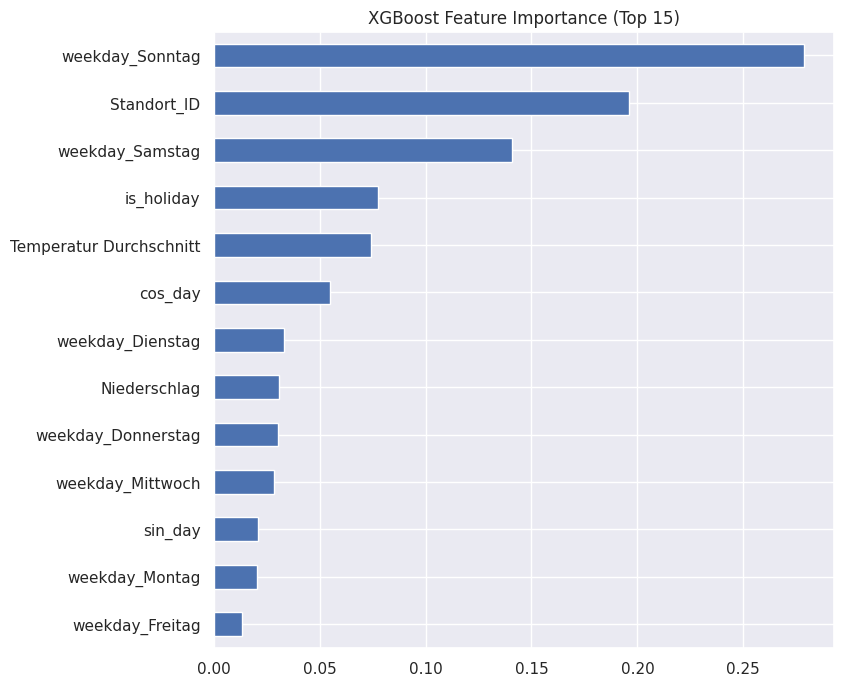

In [12]:
importances_xgb = pd.Series(xgb.feature_importances_, index=features)
importances_xgb.sort_values().tail(15).plot(kind="barh", figsize=(8,8))
plt.title("XGBoost Feature Importance (Top 15)")
plt.show()

In [13]:
# Export

df.to_csv("/content/drive/MyDrive/CAS/VeloCheckZH/data/processed/data_for_model_engineered_modelled.csv", index=False)

#